In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("avail_data.csv", parse_dates=['측정시간'], encoding='cp949').sort_values('측정시간').dropna().reset_index(drop=True)
data

,측정시간,온오프라인여부,상향파워1,상향파워2,상향SNR,하향파워,하향SNR,셀번호
0,2024-04-01 00:20:00,online,-4.0,36.0,30.0,-6.0,38.0,YSJBF3-2
1,2024-04-01 00:20:00,online,1.0,52.0,30.0,5.0,38.0,YSHS0015
2,2024-04-01 00:20:00,online,-1.0,47.0,30.0,0.0,38.0,YSYW0009
3,2024-04-01 00:20:00,online,0.0,26.0,34.0,5.0,42.0,YSHS0043
4,2024-04-01 00:20:00,online,0.0,41.0,30.0,0.0,36.0,YSYW0063B
...,...,...,...,...,...,...,...,...
235578,2024-05-01 23:00:00,online,3.0,38.0,26.0,-3.0,38.0,YSDGHFC0054
235579,2024-05-01 23:00:00,w-online,0.0,40.0,32.0,2.0,43.0,YSWS0154
235580,2024-05-01 23:00:00,online,0.0,50.0,33.0,2.0,42.0,YSWS0051
235581,2024-05-01 23:00:00,w-online,0.0,41.0,31.0,-2.0,35.0,YSWS6-2


In [2]:
outlier = pd.read_csv("장애내역.csv", encoding='cp949').drop_duplicates().reset_index(drop=True)
outlier['측정시간'] = outlier['측정시간'].str.replace("+09:00", "")
outlier['측정시간'] = pd.to_datetime(outlier['측정시간'])
outlier

,셀번호,측정시간,장애여부
0,YSWS4-5,2024-04-01 10:34:43,MAJOR
1,YSSB1-6,2024-04-01 11:13:33,MAJOR
2,YSWS0244,2024-04-01 15:22:45,CRITICAL
3,YSWSG3-4B,2024-04-02 10:54:25,MAJOR
4,YSJB5-25,2024-04-02 13:41:30,MAJOR
...,...,...,...
181,YSYW0030,2024-04-30 09:33:27,MAJOR
182,YSYW0030,2024-04-30 10:01:47,CRITICAL
183,YSWS8-5,2024-04-30 14:31:26,MAJOR
184,YSYW0009,2024-04-30 14:44:35,MAJOR


In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

data = data.drop(columns=['상향파워1'])

def find_nearest_time(df, target_time, cell_number):
    if cell_number in df['셀번호'].unique():
        temp_df = df[df['측정시간'] <= target_time]
        temp_df = temp_df[temp_df['셀번호'] == cell_number]
        
        if len(temp_df) != 0:
            return temp_df.iloc[-1]

merged = []
for _, row in outlier.iterrows():
    nearest_row = find_nearest_time(data, row['측정시간'], row['셀번호'])
    if nearest_row is not None:
        nearest_row['장애여부'] = 1
        merged.append(nearest_row)

merged_df = pd.DataFrame(merged)
merged_df = merged_df.drop_duplicates()
merged_df

,측정시간,온오프라인여부,상향파워2,상향SNR,하향파워,하향SNR,셀번호,장애여부
2164,2024-04-01 09:00:00,online,42.0,30.0,-4.0,39.0,YSWS4-5,1
2686,2024-04-01 10:10:00,online,33.0,31.0,-6.0,35.0,YSSB1-6,1
11427,2024-04-02 10:50:00,online,35.0,33.0,6.0,42.0,YSWSG3-4B,1
11350,2024-04-02 10:30:00,online,30.0,34.0,3.0,36.0,YSJB5-25,1
20268,2024-04-03 08:50:00,online,40.0,30.0,9.0,42.0,YSJSC2003,1
...,...,...,...,...,...,...,...,...
226336,2024-04-30 09:00:00,w-online,54.0,26.0,16.0,41.0,YSYW0030,1
226497,2024-04-30 10:00:00,online,55.0,30.0,0.0,39.0,YSYW0030,1
209645,2024-04-27 21:45:00,online,48.0,31.0,-4.0,39.0,YSWS8-5,1
227588,2024-04-30 14:35:00,w-online,42.0,30.0,-7.0,38.0,YSYW0009,1


In [4]:
data['장애여부'] = 0
data['장애여부'].loc[merged_df.index] = 1
# data['온오프라인여부'].value_counts()

In [5]:
data['일'] = data['측정시간'].dt.day
data['시'] = data['측정시간'].dt.hour
data['분'] = data['측정시간'].dt.minute
data['요일'] = data['측정시간'].dt.weekday
data = data.drop(columns=['측정시간'])
data

,온오프라인여부,상향파워2,상향SNR,하향파워,하향SNR,셀번호,장애여부,일,시,분,요일
0,online,36.0,30.0,-6.0,38.0,YSJBF3-2,0,1,0,20,0
1,online,52.0,30.0,5.0,38.0,YSHS0015,0,1,0,20,0
2,online,47.0,30.0,0.0,38.0,YSYW0009,0,1,0,20,0
3,online,26.0,34.0,5.0,42.0,YSHS0043,0,1,0,20,0
4,online,41.0,30.0,0.0,36.0,YSYW0063B,0,1,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...
235578,online,38.0,26.0,-3.0,38.0,YSDGHFC0054,0,1,23,0,2
235579,w-online,40.0,32.0,2.0,43.0,YSWS0154,0,1,23,0,2
235580,online,50.0,33.0,2.0,42.0,YSWS0051,0,1,23,0,2
235581,w-online,41.0,31.0,-2.0,35.0,YSWS6-2,0,1,23,0,2


In [6]:
from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
le2 = LabelEncoder()

data['온오프라인여부'] = le1.fit_transform(data['온오프라인여부'])
data['셀번호'] = le2.fit_transform(data['셀번호'])

data = data.drop(columns=['온오프라인여부'])

data

,상향파워2,상향SNR,하향파워,하향SNR,셀번호,장애여부,일,시,분,요일
0,36.0,30.0,-6.0,38.0,42,0,1,0,20,0
1,52.0,30.0,5.0,38.0,8,0,1,0,20,0
2,47.0,30.0,0.0,38.0,92,0,1,0,20,0
3,26.0,34.0,5.0,42.0,16,0,1,0,20,0
4,41.0,30.0,0.0,36.0,96,0,1,0,20,0
...,...,...,...,...,...,...,...,...,...,...
235578,38.0,26.0,-3.0,38.0,2,0,1,23,0,2
235579,40.0,32.0,2.0,43.0,64,0,1,23,0,2
235580,50.0,33.0,2.0,42.0,62,0,1,23,0,2
235581,41.0,31.0,-2.0,35.0,88,0,1,23,0,2


In [7]:
def add_lag_features(df, group_col, target_cols, lag_num):
    temp_df = df.copy()
    for col in target_cols:
        for lag in range(1, lag_num + 1):
            temp_df[f'{col}_lag{lag}'] = temp_df.groupby(group_col)[col].shift(lag)
    return temp_df

target_cols = ['상향파워2', '상향SNR', '하향파워', '하향SNR']

lag_num=5

data_with_lags = add_lag_features(data, '셀번호', target_cols, lag_num)

data_with_lags = data_with_lags.dropna().reset_index(drop=True)
data_with_lags

,상향파워2,상향SNR,하향파워,하향SNR,셀번호,장애여부,일,시,분,요일,...,하향파워_lag1,하향파워_lag2,하향파워_lag3,하향파워_lag4,하향파워_lag5,하향SNR_lag1,하향SNR_lag2,하향SNR_lag3,하향SNR_lag4,하향SNR_lag5
0,42.0,29.0,-2.0,36.0,28,0,1,0,20,0,...,7.0,-2.0,-2.0,10.0,2.0,37.0,37.0,37.0,38.0,38.0
1,35.0,34.0,-1.0,37.0,2,0,1,0,20,0,...,0.0,-2.0,1.0,1.0,-2.0,37.0,35.0,37.0,37.0,36.0
2,43.0,26.0,3.0,37.0,28,0,1,0,20,0,...,-2.0,7.0,-2.0,-2.0,10.0,36.0,37.0,37.0,37.0,38.0
3,46.0,28.0,-4.0,38.0,2,0,1,0,20,0,...,-1.0,0.0,-2.0,1.0,1.0,37.0,37.0,35.0,37.0,37.0
4,45.0,28.0,4.0,38.0,2,0,1,0,20,0,...,-4.0,-1.0,0.0,-2.0,1.0,38.0,37.0,37.0,35.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235086,38.0,26.0,-3.0,38.0,2,0,1,23,0,2,...,3.0,-1.0,0.0,-5.0,-9.0,38.0,38.0,37.0,36.0,38.0
235087,40.0,32.0,2.0,43.0,64,0,1,23,0,2,...,-5.0,2.0,23.0,5.0,4.0,41.0,43.0,44.0,41.0,41.0
235088,50.0,33.0,2.0,42.0,62,0,1,23,0,2,...,1.0,2.0,9.0,1.0,0.0,41.0,41.0,41.0,41.0,40.0
235089,41.0,31.0,-2.0,35.0,88,0,1,23,0,2,...,-1.0,-2.0,-1.0,-1.0,-3.0,36.0,35.0,36.0,36.0,39.0


  0%|          | 0/199 [00:00<?, ?it/s]

Best Threshold: 0.033
Best F1 Score: 0.1270
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46991
           1       0.11      0.14      0.13        28

    accuracy                           1.00     47019
   macro avg       0.56      0.57      0.56     47019
weighted avg       1.00      1.00      1.00     47019



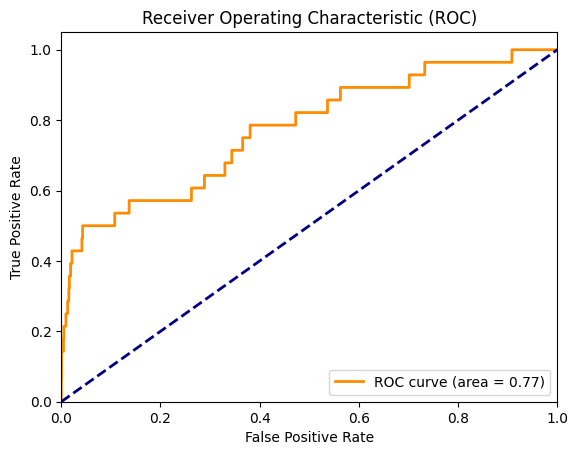

[[46960    31]
 [   24     4]]


In [15]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tqdm.auto import tqdm

X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

model = XGBClassifier(learning_rate=0.1, n_estimators=1000)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
model.save_model("xgb_model.json")

best_threshold = 0
best_f1_score = 0
y_proba = model.predict_proba(X_test)[:, 1]

for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    y_pred = y_proba > threshold
    f1 = f1_score(y_test, y_pred)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

y_pred = y_proba > best_threshold

print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(confusion_matrix(y_test, y_pred))

In [10]:
X_test['고장확률'] = y_proba
X_test['실제장애여부'] = y_test
X_test.sort_values('고장확률', ascending=False)[:50]

,상향파워2,상향SNR,하향파워,하향SNR,셀번호,일,시,분,요일,상향파워2_lag1,...,하향파워_lag3,하향파워_lag4,하향파워_lag5,하향SNR_lag1,하향SNR_lag2,하향SNR_lag3,하향SNR_lag4,하향SNR_lag5,고장확률,실제장애여부
147245,54.0,36.0,1.0,40.0,33,18,2,5,3,46.0,...,2.0,0.0,-3.0,36.0,38.0,37.0,38.0,38.0,0.247712,0
147422,0.0,36.0,0.0,0.0,23,18,2,25,3,42.0,...,2.0,10.0,10.0,39.0,40.0,40.0,40.0,39.0,0.217787,1
147516,51.0,36.0,-9.0,26.0,34,18,2,35,3,35.0,...,-6.0,0.0,-5.0,27.0,26.0,38.0,37.0,38.0,0.186204,0
129227,54.0,35.0,0.0,43.0,75,15,13,15,0,52.0,...,4.0,4.0,0.0,41.0,45.0,40.0,41.0,43.0,0.180122,0
125308,51.0,35.0,2.0,43.0,75,15,1,5,0,54.0,...,5.0,-1.0,0.0,40.0,43.0,39.0,44.0,41.0,0.163571,0
147490,0.0,35.0,0.0,0.0,10,18,2,35,3,45.0,...,0.0,0.0,3.0,41.0,38.0,39.0,39.0,38.0,0.156219,0
147654,49.0,31.0,0.0,40.0,35,18,3,5,3,0.0,...,2.0,2.0,2.0,0.0,40.0,40.0,40.0,40.0,0.146428,0
147060,37.0,33.0,3.0,38.0,24,18,1,25,3,35.0,...,-6.0,-4.0,-3.0,38.0,40.0,34.0,35.0,38.0,0.134630,0
147790,57.0,33.0,-8.0,36.0,7,18,3,5,3,50.0,...,4.0,3.0,7.0,37.0,37.0,40.0,41.0,38.0,0.113125,0
147489,0.0,36.0,0.0,0.0,31,18,2,35,3,37.0,...,10.0,10.0,0.0,39.0,40.0,40.0,40.0,39.0,0.096944,0


In [ ]:
import shap

feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Best Threshold: 0.043
Best F1 Score: 0.0956
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    234953
           1       0.11      0.09      0.10       138

    accuracy                           1.00    235091
   macro avg       0.55      0.54      0.55    235091
weighted avg       1.00      1.00      1.00    235091



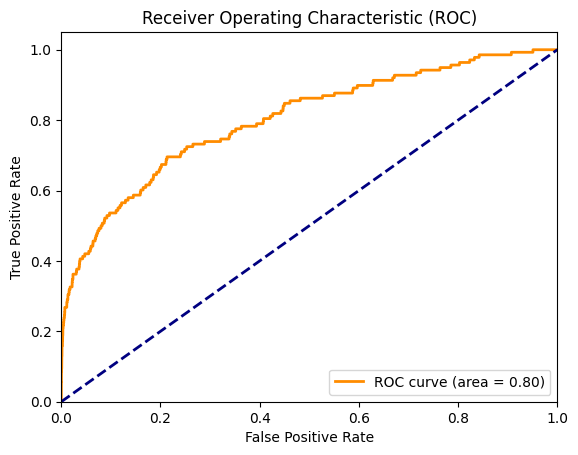

[[234852    101]
 [   126     12]]


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tqdm.auto import tqdm
from catboost import CatBoostClassifier

X = data_with_lags.drop(columns=['장애여부'])
y = data_with_lags['장애여부']

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=30)

oof_preds = np.zeros(X.shape[0])

for train_idx, valid_idx in tqdm(skf.split(X, y), total=n_splits):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = XGBClassifier(learning_rate=0.1, n_estimators=1000)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=50)
    
    oof_preds[valid_idx] = model.predict_proba(X_valid)[:, 1]

best_threshold = 0
best_f1_score = 0

for threshold in tqdm(np.arange(0.2, 0.001, -0.001)):
    oof_predict = oof_preds > threshold
    f1 = f1_score(y, oof_predict)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.3f}')
print(f'Best F1 Score: {best_f1_score:.4f}')

oof_predict = oof_preds > best_threshold
print(classification_report(y, oof_predict))

fpr, tpr, _ = roc_curve(y, oof_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(confusion_matrix(y, oof_predict))

In [ ]:
import shap

feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [12]:
X['고장확률'] = oof_preds
X['실제장애여부'] = y
X.sort_values('고장확률', ascending=False)[:50]

,상향파워2,상향SNR,하향파워,하향SNR,셀번호,일,시,분,요일,상향파워2_lag1,...,하향파워_lag3,하향파워_lag4,하향파워_lag5,하향SNR_lag1,하향SNR_lag2,하향SNR_lag3,하향SNR_lag4,하향SNR_lag5,고장확률,실제장애여부
147489,0.0,36.0,0.0,0.0,31,18,2,35,3,37.0,...,10.0,10.0,0.0,39.0,40.0,40.0,40.0,39.0,0.348018,0
129306,54.0,36.0,2.0,42.0,75,15,13,25,0,54.0,...,3.0,4.0,9.0,41.0,45.0,42.0,41.0,42.0,0.309064,0
142449,30.0,36.0,15.0,37.0,27,17,11,35,2,29.0,...,15.0,15.0,15.0,37.0,37.0,37.0,37.0,37.0,0.251516,0
147594,0.0,36.0,0.0,0.0,35,18,2,55,3,47.0,...,2.0,2.0,2.0,40.0,40.0,40.0,40.0,40.0,0.224898,0
126478,54.0,0.0,4.0,40.0,75,15,5,15,0,54.0,...,4.0,2.0,5.0,43.0,43.0,40.0,43.0,42.0,0.206567,0
129227,54.0,35.0,0.0,43.0,75,15,13,15,0,52.0,...,4.0,4.0,0.0,41.0,45.0,40.0,41.0,43.0,0.201378,0
147398,46.0,36.0,1.0,38.0,34,18,2,25,3,35.0,...,5.0,-4.0,-5.0,40.0,39.0,40.0,38.0,38.0,0.164797,0
147329,27.0,34.0,5.0,42.0,16,18,2,15,3,36.0,...,3.0,4.0,3.0,39.0,42.0,39.0,39.0,39.0,0.160575,1
147424,0.0,32.0,0.0,0.0,13,18,2,25,3,0.0,...,16.0,11.0,6.0,0.0,42.0,39.0,40.0,37.0,0.150419,0
147422,0.0,36.0,0.0,0.0,23,18,2,25,3,42.0,...,2.0,10.0,10.0,39.0,40.0,40.0,40.0,39.0,0.144357,1
